# Identifying Customer Needs from User-Generated Content.

### File: demo_Preprocessing
This script shows the example result of embedding.

In [8]:
import os
import re
import csv 
import gzip
from collections import defaultdict
import numpy as np   
from gensim.models import Word2Vec, Phrases  # Updated gensim API
from nltk.corpus import stopwords
import warnings
np.random.seed(42)

def clean_str(string, cachedStopWords):

    """
    Clean and tokenize the text.
    """
    string = string.strip().lower()
    string = re.sub(r'(&quot;|&#[A-Za-z0-9]+;|br /)', ' ', string)
    string = re.sub(r'[^a-z]', ' ', string)
    string = re.sub(r'\s+', ' ', string)
    cleaned_words = [word for word in string.split() if word not in cachedStopWords]

    return ' '.join(cleaned_words).strip()


def createEmb(phase0File):

    """
    Create word embeddings using Word2Vec.
    """

    sentences = []
    cachedStopWords = stopwords.words("english")


    with open(phase0File, 'r', newline='', encoding='utf-8') as csvfile:
        sentences_csv = csv.reader(csvfile)
        for row in sentences_csv:
            sent = clean_str(row[0], cachedStopWords)
            sentences.append(sent.split())
    
    # Build a bigram transformer from the sentences.
    bigram_transformer = Phrases(sentences)
    sentences_bigrams = list(bigram_transformer[sentences])

    # Use updated gensim parameters (vector_size instead of size)
    model = Word2Vec(min_count=5, vector_size=20,
                     workers=4, sg=1, negative=10, seed=1)
    model.build_vocab(sentences_bigrams)
    model.train(sentences_bigrams, total_examples=model.corpus_count, epochs=model.epochs)
    
    allEmb = defaultdict(list)
    # Iterate over words using model.wv.index_to_key (gensim 4.x)
    for word in model.wv.index_to_key:
        allEmb[word] = model.wv[word].tolist()
    
    return allEmb, bigram_transformer


    
def prepSent(sentOrig, bigram_trans):

    """
    Preprocess sentences using cleaning and bigram transformation.
    """

    sentPrep = defaultdict(list)    
    cachedStopWords = stopwords.words("english")

    for sent_id, sent_text in sentOrig.items():
        cleaned = clean_str(sent_text, cachedStopWords).split()
        sentPrep[sent_id] = list(bigram_trans[cleaned])

    return sentPrep


def cleanEmb(allEmb, sentPrep):

    """
    Ensure that every word in the preprocessed sentences has an embedding. For missing words, assign a random vector.
    """

    vocab = {w for words in sentPrep.values() for w in words}    
    newEmb = defaultdict(list)

    for w in vocab:
        if w in allEmb:
            newEmb[w] = allEmb[w]
        else:
            newEmb[w] = np.random.uniform(-0.25, 0.25, 20).tolist()

    return newEmb


def embSent(allEmb, sentPrep):

    """
    Compute sentence embeddings as the average of their word embeddings.
    """

    sentEmb = defaultdict(list)

    for snt, words in sentPrep.items():
        if words:  # Avoid division by zero for empty sentences.
            emb = np.zeros(20)
            for w in words:
                emb += np.array(allEmb[w])
            emb /= len(words)
            sentEmb[snt] = emb.tolist()
        else:
            sentEmb[snt] = np.zeros(20).tolist()

    return sentEmb

    

if __name__ == "__main__":

    warnings.filterwarnings("ignore")
    phase0File   = '../data/all_sentences.csv'
    test_sentence = "Well I really don't know how well the 4-pack of Teledyne piks (BRJ4) works because, even though it's clearly what I ordered, Goodman's, without notice,  sent me the Official WaterPik 2-Pack (JT-70E) in its place for the same total cost to me as what I had paid for the Teledyne 4-pack.Two piks in place of four? In New York."
    allEmb, bigram_trans = createEmb(phase0File)
    sentOrig = {0: test_sentence}
    sentPrep = prepSent(sentOrig, bigram_trans)
    allEmb = cleanEmb(allEmb, sentPrep)
    sentEmb = embSent(allEmb, sentPrep)


    print("Original sentence:")
    print(sentOrig[0])
    print("\nPreprocessed sentence:")
    print(sentPrep[0])
    print("\nSentence embedding:")
    print(sentEmb[0])
    print("\n")
    print("Done!")


Original sentence:
Well I really don't know how well the 4-pack of Teledyne piks (BRJ4) works because, even though it's clearly what I ordered, Goodman's, without notice,  sent me the Official WaterPik 2-Pack (JT-70E) in its place for the same total cost to me as what I had paid for the Teledyne 4-pack.Two piks in place of four? In New York.

Preprocessed sentence:
['well', 'really', 'know', 'well', 'pack', 'teledyne', 'piks', 'brj', 'works', 'even_though', 'clearly', 'ordered', 'goodman', 'without', 'notice', 'sent', 'official', 'waterpik', 'pack', 'jt', 'e', 'place', 'total', 'cost', 'paid', 'teledyne', 'pack', 'two', 'piks', 'place', 'four', 'new_york']

Sentence embedding:
[0.17269090155605227, -0.2941712515312247, 0.3649288908636663, -0.04047667287522927, -0.4747135156067088, 0.18324328897506348, 0.04350585656356998, 0.8650363604538143, -0.5814319197670557, 0.575916666071862, 0.2291735845938092, -0.19675509561784565, 0.4787332192645408, -0.298412085567179, 0.4222867185017094, 0.28

### 'Preprocessing': 
This script is a modified version of the original preprocessing pipeline described in Timoshenko & Hauser (2019), and it corresponds to Stage 1 in their 5-step system for extracting customer needs from user-generated content (UGC).
1) Sentence Segmentation: Splits large chunks of UGC into individual sentences, using a sentence tokenizer (like NLTK’s Punkt or a regex-based approach).
2) Text Cleaning: Removes Stopwords (e.g., “the”, “and”), Non-alphanumeric symbols (e.g., punctuation, emojis), Numbers, replacing them with a # symbol, Converts all text to lowercase
3) Bigram Merging: Frequently co-occurring word pairs (e.g., 'oral care, 'bad breath') are joined using an underscore (e.g., oral_care). This helps retain meaningful multi-word expressions in the word embedding stage.
4) Sentence Length Filtering: Keeps only sentences that are between 4 and 14 words long after cleaning. This removes outliers: short fragments and overly long or compound sentences (which may lack a clear, focused need).
5) Write Output

In [9]:
import os
import re
import csv
import gzip
from collections import defaultdict
import numpy as np   
from gensim.models import Word2Vec, Phrases  # Updated gensim API
from nltk.corpus import stopwords
import warnings

np.random.seed(42)

def clean_str(string, cachedStopWords):

    """
    Clean and tokenize the text.
    """

    string = string.strip().lower()
    string = re.sub(r'(&quot;|&#[A-Za-z0-9]+;|br /)', ' ', string)
    string = re.sub(r'[^a-z]', ' ', string)
    string = re.sub(r'\s+', ' ', string)
    cleaned_words = [word for word in string.split() if word not in cachedStopWords]

    return ' '.join(cleaned_words).strip()


def createEmb(phase0File):

    """
    Create word embeddings using Word2Vec.
    """

    sentences = []
    cachedStopWords = stopwords.words("english")


    with open(phase0File, 'r', newline='', encoding='utf-8') as csvfile:
        sentences_csv = csv.reader(csvfile)
        for row in sentences_csv:
            sent = clean_str(row[0], cachedStopWords)
            sentences.append(sent.split())
    
    # Build a bigram transformer from the sentences.
    bigram_transformer = Phrases(sentences)
    sentences_bigrams = list(bigram_transformer[sentences])
    # Use updated gensim parameters (vector_size instead of size)
    model = Word2Vec(min_count=5, vector_size=20,
                     workers=4, sg=1, negative=10, seed=1)
    model.build_vocab(sentences_bigrams)
    model.train(sentences_bigrams, total_examples=model.corpus_count, epochs=model.epochs)

    allEmb = defaultdict(list)
    # Iterate over words using model.wv.index_to_key (gensim 4.x)
    for word in model.wv.index_to_key:
        allEmb[word] = model.wv[word].tolist()
   
    return allEmb, bigram_transformer


def readSent(sentFile):

    """
    Read sentences from a CSV file.
    Expected CSV format:
      - Column 0: Sentence ID
      - Column 1: Sentence label
      - Column 2 onward: Sentence text parts (the first nonempty one is used)
    """

    sentOrig = defaultdict(str)
    sentLabel = defaultdict(int)

    with open(sentFile, 'r', newline='', encoding='utf-8') as csvfile:
        sent_csv = csv.reader(csvfile)
        next(sent_csv)  
        for row in sent_csv:
            filtered = list(filter(None, row[2:]))
            sentOrig[row[0]] = filtered[0] if filtered else ""
            sentLabel[row[0]] = int(row[1])

    return sentOrig, sentLabel

    
def prepSent(sentOrig, bigram_trans):

    """
    Preprocess sentences using cleaning and bigram transformation.
    """

    sentPrep = defaultdict(list)    
    cachedStopWords = stopwords.words("english")

    
    for sent_id, sent_text in sentOrig.items():
        cleaned = clean_str(sent_text, cachedStopWords).split()
        sentPrep[sent_id] = list(bigram_trans[cleaned])

    return sentPrep


def cleanEmb(allEmb, sentPrep):

    """
    Ensure that every word in the preprocessed sentences has an embedding.
    For missing words, assign a random vector.
    """

    vocab = {w for words in sentPrep.values() for w in words}    
    newEmb = defaultdict(list)

    for w in vocab:
        if w in allEmb:
            newEmb[w] = allEmb[w]
        else:
            newEmb[w] = np.random.uniform(-0.25, 0.25, 20).tolist()

    return newEmb


def embSent(allEmb, sentPrep):

    """
    Compute sentence embeddings as the average of their word embeddings.
    """

    sentEmb = defaultdict(list)
    for snt, words in sentPrep.items():
        if words:  # Avoid division by zero for empty sentences.
            emb = np.zeros(20)
            for w in words:
                emb += np.array(allEmb[w])
            emb /= len(words)
            sentEmb[snt] = emb.tolist()
        else:
            sentEmb[snt] = np.zeros(20).tolist()

    return sentEmb

    
def writeEmb(emb_obj, fname_short):

    """
    Write embeddings to a text file and compress the file using gzip.
    """

    # Write to a temporary text file in UTF-8.
    with open(fname_short, 'w', encoding='utf-8') as f_txt:
        for word, vec in emb_obj.items():
            line = word + ' ' + ' '.join(map(str, vec)) + '\n'
            f_txt.write(line)

    
    # Compress the text file.
    with open(fname_short, 'r', encoding='utf-8') as f_in:
        with gzip.open(fname_short + '.gz', 'wt', encoding='utf-8') as f_out:
            f_out.writelines(f_in)

    os.remove(fname_short)

    
def writePrepSent(sentPrep, sentLabel, prepFile):

    """
    Write preprocessed sentences (with labels) to a text file and compress it.
    """

    with open(prepFile, 'w', encoding='utf-8') as f_txt:
        for sent_id, words in sentPrep.items():
            line = sent_id + ' ' + str(sentLabel[sent_id]) + ' ' + ' '.join(words) + '\n'
            f_txt.write(line)

    
    with open(prepFile, 'r', encoding='utf-8') as f_in:
        with gzip.open(prepFile + '.gz', 'wt', encoding='utf-8') as f_out:
            f_out.writelines(f_in)
    os.remove(prepFile)

    
def readNeedID(needFile):

    """
    Read customer need IDs from a CSV file.
    """

    sentNeedID = defaultdict(list)

    with open(needFile, 'r', newline='', encoding='utf-8') as csvfile:
        need_csv = csv.reader(csvfile)
        next(need_csv)  # Skip header row
        for row in need_csv:
            sentNeedID[row[0]] = list(filter(None, row[1:]))

    return sentNeedID


if __name__ == "__main__":
    warnings.filterwarnings("ignore")

    phase0File   = '../data/all_sentences.csv'
    phase1File   = '../data/8000_sentences.csv'
    phase2File   = '../data/identified_needs.csv'
    ShortEmbFile = '../temp/short_emb_20.txt'
    SentEmbFile  = '../temp/sent_emb_20.txt'
    prepSentFile = '../temp/preprocessed_snts.txt'

    allEmb, bigram_trans = createEmb(phase0File)
    sentOrig, sentLabel = readSent(phase1File)
    sentPrep = prepSent(sentOrig, bigram_trans)
    allEmb = cleanEmb(allEmb, sentPrep)
    sentEmb = embSent(allEmb, sentPrep)
    sentNeedID = readNeedID(phase2File)

    
    # Filter sentences based on length criteria.
    prepSnts = {sent_id: words for sent_id, words in sentPrep.items() if 3 < len(words) <= 14}
    writeEmb(allEmb, ShortEmbFile)
    writeEmb(sentEmb, SentEmbFile)
    writePrepSent(prepSnts, sentLabel, prepSentFile)


### Figure_5_shuyi

Figure 5 in Timoshenko & Hauser (2019) shows how the F1-score of a CNN classifier improves with increasing labeled training data.
This script is an updated version:
Identifying Customer Needs from User-Generated Content by Artem Timoshenko and John R. Hauser.
I made changes to match python 3 and the updated version of keras.

Purpose: To evaluate how much labeled training data is needed before the CNN classifier stabilizes in its performance. This helps determine the trade-off between annotation effort and model performance.
Method: The authors randomly sample different-sized training sets (from small to large). For each size, they train the CNN 100 times, compute the F1-score, and plot the average.
Result: Performance stabilizes around 500 labeled sentences. This suggests that a relatively small set of labeled data is sufficient to train a reasonably good classifier for identifying informative sentences.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Done 0 runs for trainLen=100. Completed 0.0%
Done 0 runs for trainLen=250. Completed 0.0%
Done 0 runs for trainLen=500. Completed 0.0%
Done 0 runs for trainLen=1000. Completed 0.0%
Done 0 runs for trainLen=1500. Completed 0.0%
Done 0 runs for trainLen=2000. Completed 0.0%
Done 0 runs for trainLen=2500. Completed 0.0%
Done 0 runs for trainLen=3000. Completed 0.0%
Done 0 runs for trainLen=3500. Completed 0.0%
Done 0 runs for trainLen=4000. Completed 0.0%


[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:  3.8min remaining:  5.7min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  6.9min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 10.3min finished


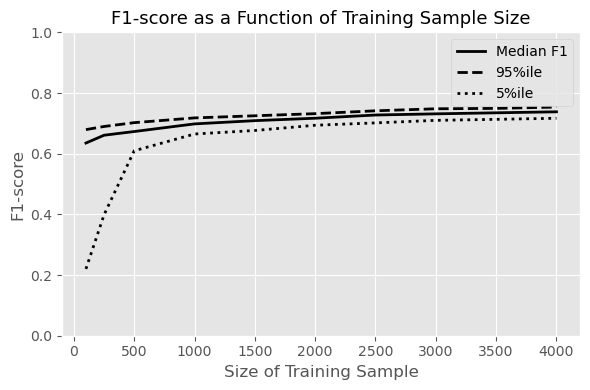

Done.


In [10]:
import gzip
import csv
import random
import warnings
from collections import defaultdict
from joblib import Parallel, delayed
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

torch.manual_seed(42)
np.random.seed(42)


def readEmb(embFile: str) -> dict:
    """
    Reads (word -> embedding) mappings from a gzipped text file.
    param embFile: Path to the gzipped embeddings file. Each line has: word val1 val2 ... valN
    :return: A dictionary mapping {word: list of floats (embedding)}.
    """

    word_vecs = {}
    # "rt" mode => read text from compressed file in Python 3
    with gzip.open(embFile, "rt", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split()
            if not parts:
                continue
            word = parts[0]
            emb = [float(s) for s in parts[1:]]
            word_vecs[word] = emb
    return word_vecs


def readPrepSent(prepFile: str) -> tuple[dict, dict]:
    """
    Reads preprocessed sentences from a gzipped file, each line with: sentID label word1 word2 ...
    Returns dictionaries: sentPrep (token lists) and sentLabel (binary labels).
    param prepFile: Path to the gzipped file with preprocessed sentences.
    return: (sentPrep, sentLabel)
             sentPrep[sentID] = [word1, word2, ...]
             sentLabel[sentID] = int(label)
    """

    sentPrep = defaultdict(list)
    sentLabel = defaultdict(int)

    with gzip.open(prepFile, "rt", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split()
            if not parts:
                continue
            sentID = parts[0]
            label = int(parts[1])
            words = parts[2:]
            sentPrep[sentID] = words
            sentLabel[sentID] = label
    return sentPrep, sentLabel


def readNeedID(needFile: str) -> dict:
    """
    Reads a CSV file with identified needs. Expects a header, then each line: sentID, need1, need2, ...
    Returns a dict mapping sentID -> list of needIDs.
    param needFile: Path to CSV.
    return: dict[sentID -> list of needs]
    """

    sentNeedID = defaultdict(list)

    with open(needFile, 'r', newline='', encoding='utf-8') as csvfile:
        need_csv = csv.reader(csvfile)
        next(need_csv)  # Skip header
        for row in need_csv:
            if not row:
                continue
            sentID = row[0]
            needs = [x for x in row[1:] if x]  # filter out empty strings
            sentNeedID[sentID] = needs
    return sentNeedID


def padSent(sentPrep: dict, wEmb: dict) -> tuple[dict, dict]: # Pad is done at the end of the sentence for some reason. For pytorch, we can pad on both sides.
    """
    Pads sentences to the max length found. A <PAD> token is used, with an embedding of all zeros. Returns the updated sentPrep and wEmb.
    param sentPrep: dict[sentID -> list of words]
    param wEmb: dict[word -> embedding list]
    return: (updated_sentPrep, updated_wEmb)
    """

    # Find the maximum sentence length
    max_len = max(len(words) for words in sentPrep.values())
    # Add <PAD> token to embeddings as zero vector
    emb_dim = len(next(iter(wEmb.values())))  # dimension of embeddings
    wEmb['<PAD>'] = [0.0] * emb_dim

    # Pad each sentence to max_len
    for snt, words in sentPrep.items():
        needed = max_len - len(words)
        if needed > 0:
            sentPrep[snt].extend(['<PAD>'] * needed)
    return sentPrep, wEmb


def dataCNN(
    sentTrain: list,
    wEmb: dict,
    sentPrep: dict,
    sentLabel: dict
) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, dict]:
    
    """
      - Builds a vocabulary index from wEmb (word->int).
      - Creates x_train, y_train Tensors.
      - Creates a Tensor for embedding weights.
    param sentTrain: list of sentence IDs for training
    param wEmb: dict[word -> embedding vector]
    param sentPrep: dict[sentID -> list of words]
    param sentLabel: dict[sentID -> int label]
    return: (x_train, y_train, emb_weights, vocab)
    """

    # Build a vocab index from wEmb
    vocab_in = list(wEmb.keys())
    vocab = {w: i for i, w in enumerate(vocab_in)} # word -> index
    # Create x_train by mapping words to their vocab index
    x_list = []
    for snt in sentTrain:
        idxs = [vocab[w] for w in sentPrep[snt]] # map words to indices. a list of indices
        x_list.append(idxs)
    x_train = torch.tensor(x_list, dtype=torch.long)

    # Create y_train
    y_list = [sentLabel[snt] for snt in sentTrain] # list of labels
    y_train = torch.tensor(y_list, dtype=torch.float)

    # Create the embedding weights matrix
    embW_list = []
    for w in vocab_in:
        embW_list.append(wEmb[w])
    embW_tensor = torch.tensor(embW_list, dtype=torch.float)

    return x_train, y_train, embW_tensor, vocab

# The x_train now look like this:
# tensor([[  0,   1,   2,  ...,  13,  14,  15],
#         [ 16,  17,  18,  ...,  13,  14,  15],
#         [ 16,  17,  18,  ...,  13,  14,  15],
#         ...,
#         [ 16,  17,  18,  ...,  13,  14,  15],
#         [ 16,  17,  18,  ...,  13,  14,  15],
#         [ 16,  17,  18,  ...,  13,  14,  15]])
# The y_train now look like this:
# tensor([0., 0., 0.,  ..., 0., 0., 0.])


def getMetrics(y_hat: np.ndarray, y_test: np.ndarray) -> tuple[float, float, float]:

    """
    Computes Precision, Recall, and F1 for binary classification.
    param y_hat: predicted labels (0 or 1)
    param y_test: ground-truth labels (0 or 1)
    return: (precision, recall, F1)
    """

    TP = np.sum((y_test == y_hat) & (y_test == 1))
    FP = np.sum((y_test != y_hat) & (y_test == 0))
    FN = np.sum((y_test != y_hat) & (y_test == 1))

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    if (precision + recall) > 0:
        F1 = 2 * precision * recall / (precision + recall)
    else:
        F1 = 0.0

    return precision, recall, F1



class SimpleCNN(nn.Module):
    """
    It takes as input a sentence (converted to embeddings), and outputs a binary classification: 1 = Informative, 0 = Non-informative
    Input: Sentence represented as a matrix of word embeddings    e.g., 50 words × 20-dimensional embeddings
    Convolution Layer: Applies multiple filters (kernels) of sizes 2, 3, 4 (to capture bigrams, trigrams, etc.) 
                        Each filter slides across the sentence to detect relevant patterns
    ReLU Activation: Introduces non-linearity after convolution
    Max Pooling Layer: Selects the most important feature from each filter (e.g., highest activation)
    Fully Connected Layer: Receives the pooled outputs from all filters
    Outputs a probability via sigmoid activation
    """
    def __init__(
        self,
        vocab_size: int,
        embedding_dim: int,
        emb_weights: torch.Tensor,
        filter_sizes=(3, 4, 5),
        num_filters=3,
        dropout_prob=0.3,
        sequence_length=14 # We don't really need it because torch nn by default can handle variable length

    ):

        super().__init__()
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim) # In the paper embedding_dim=20
        with torch.no_grad(): # Initialize with pre-trained embeddings from the Skip-gram model. Although I doubt if this is truely necessary.
            self.embedding.weight.copy_(emb_weights)
        # Dropout. In the paper it's 0.3 HOwever, the paper does not mention where to put the dropout layer. In the initial code it is right after the embedding. I keep it the same here.
        self.dropout = nn.Dropout(dropout_prob)

        # Conv1D layers, here I follow the paper where they say they use 3 filters with size 3, 4, 5
        self.convs = nn.ModuleList([
            nn.Conv1d(
                in_channels=embedding_dim,
                out_channels=num_filters,
                kernel_size=fz,
                padding=0,  # pad with zeros to make it same length as 20 on BOTH SIDDES. In the initial code they seemingly padded on one side. 
                stride=1 # stride means how many steps the filter moves each time. In the initial code it is 1, which is just the default value.
            )
            for fz in filter_sizes
        ])


        # Final fully connected layer to 1 dimension output
        self.fc = nn.Linear(num_filters * len(filter_sizes), 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        """
        Forward pass:
        param x: shape (batch_size, sequence_length)
        return: shape (batch_size,) after sigmoid
        """
        # 1) Embedding => (batch_size, sequence_length, embedding_dim)
        emb = self.embedding(x)
        emb = self.dropout(emb) # Drop out right after embedding

        # 2) Permute for Conv1d => (batch_size, embedding_dim, sequence_length)
        emb = emb.permute(0, 2, 1)

        # 3) Convolution + Global Max Pool for each filter
        conv_results = []
        for conv in self.convs:
            c = F.relu(conv(emb))  # => (batch_size, num_filters, new_seq_len)
            # Global max pooling across time dimension
            pooled = F.max_pool1d(c, kernel_size=c.shape[2])  # => (batch_size, num_filters, 1)
            conv_results.append(pooled.squeeze(dim=2))        # => (batch_size, num_filters)

        # 4) Concatenate along channel dimension
        cat = torch.cat(conv_results, dim=1)  # => (batch_size, num_filters * len(filter_sizes))

        # 5) Fully connected => Sigmoid
        out = self.fc(cat)

        return torch.sigmoid(out).squeeze(dim=1)  # => (batch_size,)



def evalCNN(
    allSent: list,
    trainLen: int,
    wEmb: dict,
    sentPrep: dict,
    sentLabel: dict

) -> tuple[float, float, float]:

    """
    Splits the data into train/test:
       - The code randomly picks (total_sent - trainLen) for test, the rest are for train.
    Then trains a CNN on the train set, predicts on the test set, and returns (precision, recall, F1).
    param allSent: List of all sentence IDs.
    param trainLen: The number of training examples to use.
    param wEmb: The dictionary of word embeddings.
    param sentPrep: dict[sentID -> list of words].
    param sentLabel: dict[sentID -> int label].
    return: (precision, recall, F1) for the test set.
    """

    # Prepare train/test split
    tot_sent = len(allSent)
    # Select 'tot_sent - trainLen' sentences to be test
    sentTest = [allSent[i] for i in random.sample(range(tot_sent), tot_sent - trainLen)]
    sentTrain = list(set(allSent) - set(sentTest))

    # Convert them to PyTorch Tensors for our CNN
    x_train, y_train, emb_weights, vocab = dataCNN(sentTrain, wEmb, sentPrep, sentLabel)
    # Hard-coded hyperparams from original code
    sequence_length = 14  # uses a fixed length of 14
    embedding_dim = 20
    filter_sizes = (3, 4, 5)
    num_filters = 3
    dropout_prob = 0.3
    batch_size = 32
    num_epochs = 1000
    val_split = 0.1


    # Create model
    model = SimpleCNN(
        vocab_size=len(wEmb),
        embedding_dim=embedding_dim,
        emb_weights=emb_weights,
        filter_sizes=filter_sizes,
        num_filters=num_filters,
        dropout_prob=dropout_prob,
        sequence_length=sequence_length
    )


    # Decide on a device (CPU or GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Prepare an optimizer and loss function
    optimizer = optim.RMSprop(model.parameters(), lr=1e-3)
    bce_loss = nn.BCELoss()

    # Split train/val
    n_samples = x_train.shape[0]
    val_count = int(n_samples * val_split)
    train_count = n_samples - val_count
    indices = np.arange(n_samples)
    np.random.shuffle(indices) # Shuffle indices in the training set
    train_idx = indices[:train_count]
    val_idx = indices[train_count:]
    x_val = x_train[val_idx].to(device)
    y_val = y_train[val_idx].to(device)
    x_train = x_train[train_idx].to(device)
    y_train = y_train[train_idx].to(device)

    best_val_loss = float('inf')
    patience = 5
    epochs_no_improve = 0

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        # Shuffle train indices
        perm = np.random.permutation(train_count)
        for i in range(0, train_count, batch_size):
            batch_idx = perm[i:i+batch_size]
            x_batch = x_train[batch_idx]
            y_batch = y_train[batch_idx]
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = bce_loss(outputs, y_batch)
            loss.backward()
            optimizer.step()
        # Validation
        model.eval()

        with torch.no_grad():
            val_outputs = model(x_val)
            val_loss = bce_loss(val_outputs, y_val).item()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0

        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                break


    # Test data
    # Convert test set to Tensors
    x_test_list = []

    for snt in sentTest:
        x_test_list.append([vocab[w] for w in sentPrep[snt]])
    x_test = torch.tensor(x_test_list, dtype=torch.long).to(device)
    y_test = np.array([sentLabel[snt] for snt in sentTest], dtype=np.int32)

    # Predict
    model.eval()

    with torch.no_grad():
        y_probs = model(x_test).cpu().numpy()  # shape (len(sentTest),)
    # Convert to binary predictions
    y_hat = (y_probs > 0.5).astype(int)

    precision, recall, F1 = getMetrics(y_hat, y_test)

    return precision, recall, F1


# 1) Define a helper function to run T times for a single 'trainLen'
def do_experiment_for_trainLen(trainLen, allSent, wEmb, sentPrep, sentLabel, T=100):

    """
    Runs 'evalCNN' T times for a given trainLen,
    returns arrays of length T for precision, recall, F1.
    """

    prec_list = []
    rec_list = []
    f1_list = []
    
    for i in range(T):
        precision, recall, f1 = evalCNN(allSent, trainLen, wEmb, sentPrep, sentLabel)
        prec_list.append(precision)
        rec_list.append(recall)
        f1_list.append(f1)

        if i % 100 == 0:
            print(f"Done {i} runs for trainLen={trainLen}. Completed {i/T:.1%}")

    return np.array(prec_list), np.array(rec_list), np.array(f1_list)



if __name__ == "__main__":

    warnings.filterwarnings("ignore")
    random.seed(1)


    ShortEmbFile = '../temp/short_emb_20.txt.gz'
    SentEmbFile  = '../temp/sent_emb_20.txt.gz'
    prepSentFile = '../temp/preprocessed_snts.txt.gz'
    needsFile    = '../data/identified_needs.csv'

    wEmb = readEmb(ShortEmbFile)
    sntEmb = readEmb(SentEmbFile)  # not used in this snippet, but you may keep it
    sentPrep, sentLabel = readPrepSent(prepSentFile)
    sentNeedID = readNeedID(needsFile)

    # Pad sentences
    sentPrep, wEmb = padSent(sentPrep, wEmb)
    # All sentence IDs
    sentIDs = list(sentPrep.keys())
    # Different train set sizes to test
    trainLenSet = [100, 250, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]
    T = 100  # number of repeated trials

    # 3) Use parallel execution.  joblib will run do_experiment_for_trainLen(...)
    results = Parallel(n_jobs=-1, verbose=5)(
        delayed(do_experiment_for_trainLen)(trainLen, sentIDs, wEmb, sentPrep, sentLabel, T)
        for trainLen in trainLenSet
    )

    # 'results' is a list of length len(trainLenSet),
    # each element is a tuple: (prec_array, rec_array, f1_array)
    # shape: each array is (T,).

    # 4) Construct precMat, recMat, F1Mat (T x len(trainLenSet))
    precMat = np.zeros((T, len(trainLenSet)))
    recMat  = np.zeros((T, len(trainLenSet)))
    F1Mat   = np.zeros((T, len(trainLenSet)))

    for i, (prec_array, rec_array, f1_array) in enumerate(results):
        precMat[:, i] = prec_array
        recMat[:, i]  = rec_array
        F1Mat[:, i]   = f1_array

    # From here, analyze 'precMat', 'recMat', 'F1Mat' or plot them in a percentile chart, etc.
    # Example: get median, 5th percentile, 95th percentile for F1
    
    # Example plot of F1 vs. trainLenSet
    import matplotlib.pyplot as plt

    f1_5 = [np.percentile(F1Mat[:, col], 5) for col in range(len(trainLenSet))]
    f1_med = [np.percentile(F1Mat[:, col], 50) for col in range(len(trainLenSet))]
    f1_95 = [np.percentile(F1Mat[:, col], 95) for col in range(len(trainLenSet))]

    plt.figure(figsize=(6,4))
    plt.plot(trainLenSet, f1_med, label='Median F1', color='black', linewidth=2)
    plt.plot(trainLenSet, f1_95, label='95%ile', color='black', linestyle='--', linewidth=2)
    plt.plot(trainLenSet, f1_5,  label='5%ile',  color='black', linestyle=':', linewidth=2)
    plt.ylim([0,1])
    plt.xlabel('Size of Training Sample', fontsize=12)
    plt.ylabel('F1-score', fontsize=12)
    plt.legend(loc='best')
    plt.title('F1-score as a Function of Training Sample Size', fontsize=13)
    plt.tight_layout()
    plt.savefig('../figure/F1_vs_trainLen.png')
    plt.show()
    print("Done.")

### Table 2
Table 2 compares several machine learning models on their ability to classify whether a sentence from user-generated content (UGC) is informative (i.e., expresses a customer need) or not informative.

In [11]:
import gzip
import csv
import random
import warnings
from collections import defaultdict
import numpy as np
from sklearn import svm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


def readEmb(embFile: str) -> dict:

    """
    Reads word embeddings from a gzipped text file.
    The file is expected to have lines of the form: word val1 val2 ... valN
    Each line is read, split, and saved in a dictionary.
    param embFile: Path to the gzipped embedding file.
    return: Dictionary mapping {word -> embedding list[float]}.
    """

    word_vecs = {}

    with gzip.open(embFile, "rt", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split()
            if not parts:
                continue
            word = parts[0]
            emb = [float(s) for s in parts[1:]]
            word_vecs[word] = emb

    return word_vecs


def readPrepSent(prepFile: str) -> tuple[dict, dict]:

    """
    Reads preprocessed sentences from a gzipped text file.
    Each line is expected to have the format: sentID label word1 word2 ...
    Returns:
       - sentPrep: dict[sentID -> list of words]
       - sentLabel: dict[sentID -> int(label)]
    """

    sentPrep = defaultdict(list)
    sentLabel = defaultdict(int)

    with gzip.open(prepFile, "rt", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split()
            if not parts:
                continue
            sentID = parts[0]
            label = int(parts[1])
            list_words = parts[2:]
            sentPrep[sentID] = list_words
            sentLabel[sentID] = label

    return sentPrep, sentLabel


def readNeedID(needFile: str) -> dict:

    """
    Reads identified needs from a CSV file. Expects a header row, then each line: sentID, needID1, needID2, ...
    Returns a dictionary of {sentID -> [needIDs]}.
    param needFile: Path to the CSV file with identified needs.
    return: dict[sentID -> list of needIDs]
    """

    sentNeedID = defaultdict(list)

    with open(needFile, 'r', newline='', encoding='utf-8') as csvfile:
        need_csv = csv.reader(csvfile)
        next(need_csv)  

        for row in need_csv:
            if not row:
                continue
            sentID = row[0]
            # Filter out empty entries from row[1:]
            needs = [x for x in row[1:] if x]
            sentNeedID[sentID] = needs

    return sentNeedID


def padSent(sentPrep: dict, wEmb: dict, pad_token: str = "<PAD>") -> tuple[dict, dict]:

    """
    Pads all sentences in 'sentPrep' to the same length (the maximum found) by appending a special token <PAD>. The embedding for <PAD> is zero.
    param sentPrep: dict[sentID -> list of words]
    param wEmb: dict[word -> embedding vector list]
    param pad_token: special token name used for padding
    return: (updated sentPrep, updated wEmb) with uniform length sentences
    """

    # Find the max length among all sentences
    seq_len = max(len(sentPrep[snt]) for snt in sentPrep)
    # Create a zero vector for <PAD> if not already present
    wEmb[pad_token] = list(np.zeros(len(next(iter(wEmb.values())))))

    # Pad each sentence to the max length
    for snt in sentPrep:
        needed = seq_len - len(sentPrep[snt])
        if needed > 0:
            sentPrep[snt].extend([pad_token] * needed)

    return sentPrep, wEmb


def dataCNN(
    sentTrain: list,
    wEmb: dict,
    sentPrep: dict,
    sentLabel: dict
) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, dict]:

    """
    Prepares data for the CNN model:
      - Builds a vocabulary from wEmb
      - Converts words to their vocabulary indices
      - Prepares X and Y for training
      - Creates an embedding weight matrix
    param sentTrain: list of training sentence IDs
    param wEmb: dict[word -> embedding vector list]
    param sentPrep: dict[sentID -> list of words]
    param sentLabel: dict[sentID -> int label]
    return: (x_train, y_train, emb_weights, vocab)
    """

    # Build a vocabulary index {word -> idx}
    vocab_in = list(wEmb.keys())
    vocab = {w: i for i, w in enumerate(vocab_in)}

    # Convert each sentence in sentTrain to a list of vocab indices
    x_list = []
    for snt in sentTrain:
        x_list.append([vocab[w] for w in sentPrep[snt]])
    
    x_train = torch.tensor(x_list, dtype=torch.long)
    y_train = torch.tensor([sentLabel[snt] for snt in sentTrain], dtype=torch.float)


    # Create the embedding matrix
    embW = []
    for w in vocab_in:
        embW.append(wEmb[w])
    embW = torch.tensor(embW, dtype=torch.float)

    return x_train, y_train, embW, vocab


def compute_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> None:

    """
    Computes and prints Precision, Recall, F1, and Accuracy.
    param y_true: Ground-truth binary labels (NumPy array).
    param y_pred: Predicted binary labels (NumPy array).
    """

    TP = np.sum((y_true == y_pred) & (y_true == 1))
    TN = np.sum((y_true == y_pred) & (y_true == 0))
    FP = np.sum((y_true != y_pred) & (y_true == 0))
    FN = np.sum((y_true != y_pred) & (y_true == 1))
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0

    if (precision + recall) > 0:
        f1 = 2 * precision * recall / (precision + recall)
    else:
        f1 = 0.0

    accuracy = (TP + TN) / (len(y_true))

    print(f"Precision = {precision}")
    print(f"Recall = {recall}")
    print(f"F1 = {f1}")
    print(f"Accuracy = {accuracy}")

    return precision, recall, f1, accuracy


class CNN_Gamma1(nn.Module):

    """
    CNN with multiple filter sizes, global max pooling, single dense output. Uses standard binary cross-entropy.
    This replicates "CNN (gamma = 1)" from the original Keras code:
      - Embedding -> Dropout -> [Conv1D_3, Conv1D_4, Conv1D_5] -> GlobalMaxPool -> Concat -> Dense -> Sigmoid
    """

    def __init__(self, vocab_size: int, embedding_dim: int, emb_weights: torch.Tensor,
                 filter_sizes: tuple = (3,4,5), num_filters: int = 3, dropout_prob: float = 0.3):

        super().__init__()
        # Embedding layer: load external embedding weights.
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        with torch.no_grad():
            self.embedding.weight.copy_(emb_weights)
        # Allow gradient updates to the embedding by default. 
        # If you want it frozen, set 'self.embedding.weight.requires_grad = False'.

        self.dropout = nn.Dropout(dropout_prob)
        # Convolution layers (1D)
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim,
                      out_channels=num_filters,
                      kernel_size=fz)
            for fz in filter_sizes
        ])


        # Final linear projection
        self.fc = nn.Linear(num_filters * len(filter_sizes), 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        """
        param x: Tensor of shape (batch_size, seq_length)
        return: Tensor of shape (batch_size, 1) with sigmoid outputs
        """

        # x -> (batch_size, seq_length, embedding_dim)
        emb = self.embedding(x)  
        emb = self.dropout(emb)  

        # For 1D conv in PyTorch, we need shape (batch_size, embedding_dim, seq_length)
        emb = emb.permute(0, 2, 1)

        conv_outs = []

        for conv in self.convs:
            c = F.relu(conv(emb)) # => shape (batch_size, out_channels, new_seq_len)
            c = F.max_pool1d(c, kernel_size=c.shape[2])  # global max pooling over time dimension
            conv_outs.append(c.squeeze(dim=2)) # => shape (batch_size, out_channels)

        # Concatenate on channel dimension
        cat = torch.cat(conv_outs, dim=1)  # => shape (batch_size, out_channels * len(filter_sizes))
        # Dense -> Sigmoid
        out = self.fc(cat)
        out = torch.sigmoid(out).squeeze(dim=1)  # => shape (batch_size,)

        return out



class CNN_Gamma3(nn.Module):

    """
    CNN with a custom asymmetric cost function (gamma=3). Architecture is the same as CNN_Gamma1, but the loss function is replaced.
    This replicates "CNN with Asymmetric Costs" from the original Keras code:
      - Embedding -> Dropout -> [Conv1D_3, Conv1D_4, Conv1D_5] -> GlobalMaxPool -> Concat -> Dense -> Sigmoid
      - Loss = -3 * y_true * log(y_pred) - (1-y_true)*log(1-y_pred)
    """

    def __init__(self, vocab_size: int, embedding_dim: int, emb_weights: torch.Tensor,
                 filter_sizes: tuple = (3,4,5), num_filters: int = 4, dropout_prob: float = 0.4):
        
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        with torch.no_grad():
            self.embedding.weight.copy_(emb_weights)
        self.dropout = nn.Dropout(dropout_prob)
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim,
                      out_channels=num_filters,
                      kernel_size=fz)
            for fz in filter_sizes
        ])
        self.fc = nn.Linear(num_filters * len(filter_sizes), 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        emb = self.embedding(x)
        emb = self.dropout(emb)
        # Reshape to (batch_size, embedding_dim, seq_length)
        emb = emb.permute(0, 2, 1)

        conv_outs = []

        for conv in self.convs:
            c = F.relu(conv(emb))
            c = F.max_pool1d(c, kernel_size=c.shape[2])
            conv_outs.append(c.squeeze(dim=2))

        cat = torch.cat(conv_outs, dim=1)
        out = self.fc(cat)
        out = torch.sigmoid(out).squeeze(dim=1)

        return out


def custom_loss_gamma_3(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:

    """
    Implements the custom loss for gamma=3: -3 * y_true * log(y_pred) - (1 - y_true) * log(1 - y_pred)
    I clamp y_pred to avoid log(0).
    """

    eps = 1e-7
    y_pred = torch.clamp(y_pred, eps, 1.0 - eps)
    # For negative log-likelihood:
    loss = -3 * y_true * torch.log(y_pred) - (1 - y_true) * torch.log(1 - y_pred)

    return loss.mean()



class LSTMModel(nn.Module):

    """
    Recurrent Neural Network (LSTM) architecture: Embedding -> Dropout -> LSTM -> Dropout -> Dense -> Sigmoid
    """

    def __init__(self, vocab_size: int, embedding_dim: int, emb_weights: torch.Tensor,
                 hidden_size: int = 30, dropout_prob: float = 0.2):

        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        with torch.no_grad():
            self.embedding.weight.copy_(emb_weights)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True)
        self.dropout2 = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, 1)

    
    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # x -> (batch_size, seq_length)
        emb = self.embedding(x)  # => (batch_size, seq_length, embedding_dim)
        emb = self.dropout1(emb)
        # LSTM
        lstm_out, _ = self.lstm(emb)  # => (batch_size, seq_length, hidden_size)
        # Take the last hidden state from LSTM for classification
        last_hidden = lstm_out[:, -1, :]  # => (batch_size, hidden_size)
        out = self.dropout2(last_hidden)
        out = self.fc(out)  # => (batch_size, 1)
        out = torch.sigmoid(out).squeeze(dim=1)  # => (batch_size,)

        return out



class KimCNN(nn.Module):

    """
    Kim (2014) CNN: "Multi-channel CNN" approach with two embedding layers:
      - One frozen (static channel)
      - One trainable (non-static channel)
      Then they are concatenated channel-wise and fed into a Conv2D -> MaxPool -> Flatten -> Dense -> Sigmoid.
    This model replicates the "Kim (2014) CNN" portion of the code.
    """

    def __init__(self, vocab_size: int, embedding_dim: int, emb_weights: torch.Tensor, 
                 sequence_length: int = 0, n_filters: int = 10, kernel_size: int = 4, 
                 dropout_prob: float = 0.2):

        super().__init__()

        # Embedding channel 1 (frozen / non-trainable)
        self.embedding_static = nn.Embedding(vocab_size, embedding_dim)

        with torch.no_grad():
            self.embedding_static.weight.copy_(emb_weights)
        self.embedding_static.weight.requires_grad = False  # freeze

        # Embedding channel 2 (trainable)
        self.embedding_nonstatic = nn.Embedding(vocab_size, embedding_dim)

        with torch.no_grad():
            self.embedding_nonstatic.weight.copy_(emb_weights)
        self.embedding_nonstatic.weight.requires_grad = True


        # 2D convolution: input shape will be (batch_size, 2, seq_len, embed_dim)
        # Set out_channels = n_filters, kernel_size=(kernel_size, embedding_dim), so I slide only over the "seq_len" dimension (height).
        self.conv2d = nn.Conv2d(in_channels=2, out_channels=n_filters, 
                                kernel_size=(kernel_size, embedding_dim))

        # For global max-pool: pool over the entire "seq_len - kernel_size + 1" dimension plus the embedding dim dimension, but I've 
        # effectively used kernel_size to reduce embedding_dim dimension as well. So the pool shape is (seq_len-kernel_size+1, 1).
        self.sequence_length = sequence_length
        self.kernel_size = kernel_size
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(n_filters, 1)


    def forward(self, x_static: torch.Tensor, x_nonstatic: torch.Tensor) -> torch.Tensor:

        """
        x_static: batch of indices for the 'static/frozen' embedding
        x_nonstatic: batch of indices for the 'trainable' embedding
        Both are shape (batch_size, seq_length)
        """

        emb_stat = self.embedding_static(x_static)     # (batch_size, seq_len, embedding_dim)
        emb_nonstat = self.embedding_nonstatic(x_nonstatic)

        # Stack them to shape (batch_size, 2, seq_len, embedding_dim)
        # dim=1 => #channels
        merged = torch.stack((emb_stat, emb_nonstat), dim=1)  # => (batch_size, 2, seq_len, embedding_dim)

        # 2D Conv => shape (batch_size, n_filters, new_h, new_w)
        c = F.relu(self.conv2d(merged))

        # new_h = seq_len - kernel_size + 1
        # new_w = embedding_dim - embedding_dim + 1 = 1 => effectively we have shape (batch_size, n_filters, new_h, 1)
        # Global MaxPool across (new_h, 1)
        c = F.max_pool2d(c, kernel_size=(c.shape[2], c.shape[3]))  # => (batch_size, n_filters, 1, 1)
        c = c.view(c.size(0), -1)  # => (batch_size, n_filters)
        c = self.dropout(c)
        out = self.fc(c)  # => (batch_size, 1)
        out = torch.sigmoid(out).squeeze(dim=1)
        return out

def train_model(
    model: nn.Module,
    x_train: torch.Tensor,
    y_train: torch.Tensor,
    batch_size: int,
    num_epochs: int,
    val_split: float = 0.1,
    lr: float = 1e-3,
    custom_loss_fn=None,
    patience: int = 5
):

    """
    Trains the given PyTorch model with optional early stopping.
    Splits the training data into train and validation by 'val_split'.
    param model: A PyTorch model.
    param x_train: Tensor of inputs, shape (N, sequence_length) or [(N, sequence_length), ...] for multi-channel.
    param y_train: Tensor of labels, shape (N,).
    param batch_size: Mini-batch size.
    param num_epochs: Maximum number of epochs.
    param val_split: Fraction of data for validation.
    param lr: Learning rate.
    param custom_loss_fn: If provided, uses this as the loss function; else uses BCE.
    param patience: Number of epochs to wait for improvement before stopping.
    """

    model.train()

    # Determine device (CPU or GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Split into training and validation sets
    n_samples = x_train.shape[0] if isinstance(x_train, torch.Tensor) else x_train[0].shape[0]
    val_count = int(n_samples * val_split)
    train_count = n_samples - val_count

    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    train_idx = indices[:train_count]
    val_idx = indices[train_count:]

    if isinstance(x_train, torch.Tensor):
        x_train_t, x_val_t = x_train[train_idx], x_train[val_idx]
    else:
        # Multi-channel input => tuple or list of Tensors
        x_train_t = [ch[train_idx] for ch in x_train]
        x_val_t = [ch[val_idx] for ch in x_train]

    y_train_t, y_val_t = y_train[train_idx], y_train[val_idx]

    # Move data to device
    def get_batch(idx, x_data, y_data):
        if isinstance(x_data, torch.Tensor):
            return x_data[idx].to(device), y_data[idx].to(device)
        else:
            # If multi-channel, gather each channel
            return [ch[idx].to(device) for ch in x_data], y_data[idx].to(device)

    optimizer = optim.RMSprop(model.parameters(), lr=lr)


    # For binary classification
    bce_loss = nn.BCELoss()
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        permutation = np.random.permutation(train_count)

        # Mini-batch training
        for i in range(0, train_count, batch_size):
            batch_idx = permutation[i:i+batch_size]
            x_batch, y_batch = get_batch(batch_idx, x_train_t, y_train_t)
            optimizer.zero_grad()
            outputs = model(x_batch)  # shape (batch_size,)

            if custom_loss_fn:
                loss = custom_loss_fn(outputs, y_batch)
            else:
                loss = bce_loss(outputs, y_batch)

            loss.backward()
            optimizer.step()

        # Validation
        model.eval()

        with torch.no_grad():
            val_perm = np.arange(val_count)
            val_losses = []

            for i in range(0, val_count, batch_size):
                batch_idx = val_perm[i:i+batch_size]
                x_batch, y_batch = get_batch(batch_idx, x_val_t, y_val_t)
                outputs = model(x_batch)
                if custom_loss_fn:
                    vloss = custom_loss_fn(outputs, y_batch)
                else:
                    vloss = bce_loss(outputs, y_batch)
                val_losses.append(vloss.item())

            avg_val_loss = np.mean(val_losses)

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                break


def predict_model(
    model: nn.Module,
    x_test: torch.Tensor,
    batch_size: int = 32
) -> np.ndarray:

    """
    Generate predictions from the model on x_test, returning a NumPy array of binary predictions (0/1).
    param model: Trained PyTorch model.
    param x_test: Test input (Tensor).
    param batch_size: Inference batch size.
    return: NumPy array of predicted labels (0 or 1).
    """

    device = next(model.parameters()).device
    model.eval()
    preds = []
    n_samples = x_test.shape[0] if isinstance(x_test, torch.Tensor) else x_test[0].shape[0]
    indices = np.arange(n_samples)

    with torch.no_grad():
        for i in range(0, n_samples, batch_size):
            batch_idx = indices[i:i+batch_size]
            if isinstance(x_test, torch.Tensor):
                x_batch = x_test[batch_idx].to(device)
            else:
                x_batch = [ch[batch_idx].to(device) for ch in x_test]
            out = model(x_batch)
            preds.append((out.cpu().numpy() > 0.5).astype(int))

    return np.concatenate(preds, axis=0)


if __name__=="__main__":

    warnings.filterwarnings("ignore")
    ShortEmbFile  = '../temp/short_emb_20.txt.gz'
    SentEmbFile   = '../temp/sent_emb_20.txt.gz'
    prepSentFile  = '../temp/preprocessed_snts.txt.gz'
    needsFile     = '../data/identified_needs.csv'

    wEmb = readEmb(ShortEmbFile)         # word embeddings
    sntEmb = readEmb(SentEmbFile)        # sentence embeddings for SVM
    sentPrep, sentLabel = readPrepSent(prepSentFile)
    sentNeedID = readNeedID(needsFile)

    # Pad the sentences
    sentPrep, wEmb = padSent(sentPrep, wEmb)
    # Create train / test split
    allSent = list(sentPrep.keys())
    testN = 3700

    random.seed(5)
    sentTest = [allSent[i] for i in sorted(random.sample(range(len(allSent)), testN))]
    sentTrain = list(set(allSent) - set(sentTest))
    # Prepare PyTorch Tensors for CNN
    x_train_cnn, y_train_cnn, embW_cnn, vocab_cnn = dataCNN(sentTrain, wEmb, sentPrep, sentLabel)
    # Similarly for test
    x_test_cnn = torch.tensor([[vocab_cnn[w] for w in sentPrep[snt]] for snt in sentTest], dtype=torch.long)
    y_test_cnn = np.array([sentLabel[snt] for snt in sentTest])


    print("\nCNN (gamma = 1)")

    model_cnn_g1 = CNN_Gamma1(
        vocab_size=len(wEmb),
        embedding_dim=20,
        emb_weights=embW_cnn,
        filter_sizes=(3,4,5),
        num_filters=3,
        dropout_prob=0.3
    )

    train_model(
        model_cnn_g1,
        x_train_cnn,
        y_train_cnn,
        batch_size=32,
        num_epochs=40,
        val_split=0.1,
        lr=1e-3,
        custom_loss_fn=None,  # standard BCE
        patience=5
    )


    yhat_cnn_g1 = predict_model(model_cnn_g1, x_test_cnn, batch_size=32)
    print("\nTest Sample:")
    precision_g1, recall_g1, f1_g1, accuracy_g1 = compute_metrics(y_test_cnn, yhat_cnn_g1)


    print("\nCNN with Asymmetric Costs (gamma = 3)")

    model_cnn_g3 = CNN_Gamma3(
        vocab_size=len(wEmb),
        embedding_dim=20,
        emb_weights=embW_cnn,
        filter_sizes=(3,4,5),
        num_filters=4,
        dropout_prob=0.4
    )

    train_model(
        model_cnn_g3,
        x_train_cnn,
        y_train_cnn,
        batch_size=32,
        num_epochs=40,
        val_split=0.1,
        lr=1e-3,
        custom_loss_fn=custom_loss_gamma_3,  # custom asymmetric loss
        patience=5
    )

    yhat_cnn_g3 = predict_model(model_cnn_g3, x_test_cnn, batch_size=32)
    print("\nTest Sample:")
    precision_g3, recall_g3, f1_g3, accuracy_g3 = compute_metrics(y_test_cnn, yhat_cnn_g3)


    print("\nLSTM Network")

    model_lstm = LSTMModel(
        vocab_size=len(wEmb),
        embedding_dim=20,
        emb_weights=embW_cnn,
        hidden_size=30,
        dropout_prob=0.2
    )

    train_model(
        model_lstm,
        x_train_cnn,
        y_train_cnn,
        batch_size=32,
        num_epochs=40,
        val_split=0.1,
        lr=1e-3,
        custom_loss_fn=None, 
        patience=5
    )

    yhat_lstm = predict_model(model_lstm, x_test_cnn, batch_size=32)
    print("\nTest Sample:")
    precision_lstm, recall_lstm, f1_lstm, accuracy_lstm = compute_metrics(y_test_cnn, yhat_lstm)



    print("\nSimple Binary Classifier (SVM)")

    # Already have the sntEmb for each sentence. Just gather them.
    x_train_svm = np.array([sntEmb[snt] for snt in sentTrain])
    y_train_svm = np.array([sentLabel[snt] for snt in sentTrain])
    x_test_svm = np.array([sntEmb[snt] for snt in sentTest])
    clf = svm.SVC()
    clf.fit(x_train_svm, y_train_svm)
    yhat_svm = clf.predict(x_test_svm)

    print("\nTest Sample:")
    precesion_svm, recall_svm, f1_svm, accuracy_svm = compute_metrics(y_test_cnn, yhat_svm)  # y_test_cnn is same as y_test_svm


    # Print all the results in a table, where each row is the precision, recall, F1, and accuracy for each model.
    print("\nResults:")
    print("Model\t\t\tPrecision\tRecall\t\tF1\t\tAccuracy")
    print("CNN (gamma = 1)\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}".format(precision_g1, recall_g1, f1_g1, accuracy_g1))
    print("CNN (gamma = 3)\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}".format(precision_g3, recall_g3, f1_g3, accuracy_g3))
    print("LSTM Network\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}".format(precision_lstm, recall_lstm, f1_lstm, accuracy_lstm))
    print("SVM\t\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}".format(precesion_svm, recall_svm, f1_svm, accuracy_svm))# Debug or display output


CNN (gamma = 1)

Test Sample:
Precision = 0.7413127413127413
Recall = 0.7168
F1 = 0.7288503253796095
Accuracy = 0.7297297297297297

CNN with Asymmetric Costs (gamma = 3)

Test Sample:
Precision = 0.6244619799139168
Recall = 0.9285333333333333
F1 = 0.7467295732361141
Accuracy = 0.6808108108108109

LSTM Network

Test Sample:
Precision = 0.7002298850574713
Recall = 0.8122666666666667
F1 = 0.7520987654320989
Accuracy = 0.7286486486486486

Simple Binary Classifier (SVM)

Test Sample:
Precision = 0.7122153209109731
Recall = 0.7338666666666667
F1 = 0.7228789072760704
Accuracy = 0.7148648648648649

Results:
Model			Precision	Recall		F1		Accuracy
CNN (gamma = 1)		0.7413		0.7168		0.7289		0.7297
CNN (gamma = 3)		0.6245		0.9285		0.7467		0.6808
LSTM Network		0.7002		0.8123		0.7521		0.7286
SVM			0.7122		0.7339		0.7229		0.7149


### Figure_6
Figure 6: Project high-dimensional sentence embeddings (20D) into a 2D space. Then visually inspect whether sentences corresponding to different customer needs cluster separately.

The script:
1) Load Preprocessed Embeddings: The script starts by loading sentence embeddings (vectors of size 20) and their corresponding analyst-coded labels for specific customer needs.
    Example needs shown: "strong teeth and gums" vs. "shopping/product choice" in Figure 6.
2) Run PCA to reduce each 20D sentence vector into 2D. The first two principal components are retained to create a scatter plot.
3) Generate the Scatter Plot: Dots represent one need (e.g., “strong teeth and gums”). Crosses represent another (e.g., “shopping/product choice”). Ellipses are drawn to represent the 90% confidence region for each cluster of points.
4) Interpret the Visual: If clusters are well separated, it means the sentence embeddings encode meaningful semantic distinctions. That implies clustering will be effective for sampling diverse needs later.

One clear example (as shown in Figure 6) is sufficient to show that sentence embeddings can semantically distinguish between categories.

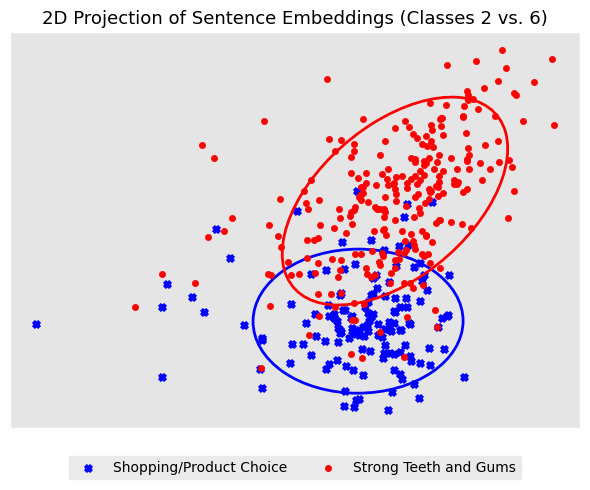

In [12]:
import csv
import gzip
import warnings
from collections import defaultdict
import numpy as np
from sklearn import decomposition
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

plt.style.use('ggplot')
np.random.seed(42)


def read_emb(emb_file: str) -> dict:

    """
    Reads word (or sentence) embeddings from a gzipped text file.
    Each line is expected to contain: word val1 val2 ... valN
    param emb_file: Path to gzipped file containing embeddings.
    return: Dictionary {word: list of float}, e.g. {"the": [0.12, 0.08, ...], ...}.
    """

    word_vecs = {}
    with gzip.open(emb_file, "rt", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split()
# Splitting string content
            if not parts:
                continue
            word = parts[0]
            emb = [float(s) for s in parts[1:]]
            word_vecs[word] = emb

    return word_vecs


def read_preprocessed_sentences(prep_file: str) -> tuple[dict, dict]:

    """
    Reads preprocessed sentences from a gzipped text file.
    Each line is expected to have: sentID label word1 word2 ...
    param prep_file: Path to gzipped file.
    return: (sentPrep, sentLabel) 
            where sentPrep[sentID] = [word1, word2, ...], 
            sentLabel[sentID] = int(label).
    """

    sent_prep = defaultdict(list)
    sent_label = defaultdict(int)

    with gzip.open(prep_file, "rt", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split()
            if not parts:
                continue
            snt_id = parts[0]
            label = int(parts[1])
            words = parts[2:]
            sent_prep[snt_id] = words
            sent_label[snt_id] = label

    return sent_prep, sent_label


def read_need_ids(need_file: str) -> dict:

    """
    Reads a CSV file containing identified needs. 
    Expects a header row, then lines of the form: sentID, need1, need2, ...
    Empty columns are filtered out.
    param need_file: Path to CSV file.
    return: Dictionary {sentID: [needIDs]}.
    """

    sent_need_id = defaultdict(list)

    with open(need_file, 'r', newline='', encoding='utf-8') as csvfile:
        need_csv = csv.reader(csvfile)
        next(need_csv) 
        for row in need_csv:
            if not row:
                continue

            snt_id = row[0]
            # Filter out empty strings in row[1:]
            needs = [n for n in row[1:] if n]
            sent_need_id[snt_id] = needs

    return sent_need_id


if __name__ == "__main__":

    warnings.filterwarnings("ignore")

    short_emb_file  = '../temp/short_emb_20.txt.gz'
    sent_emb_file   = '../temp/sent_emb_20.txt.gz'
    prep_sent_file  = '../temp/preprocessed_snts.txt.gz'
    needs_file      = '../data/identified_needs.csv'
    need_filter_file= '../data/need_filters.csv'  # Unused in this code

    w_emb = read_emb(short_emb_file)   # Word embeddings
    snt_emb = read_emb(sent_emb_file)   # Sentence embeddings
    sent_prep, sent_label = read_preprocessed_sentences(prep_sent_file)
    sent_need_id = read_need_ids(needs_file)


    # Filter classes and pick a subset
    CLA1 = 2  # e.g. "Shopping/Product Choice" class
    CLA2 = 6  # e.g. "Strong Teeth and Gums" class
    # CLA1/CLA2 are not model outputs — they are human-coded ground-truth labels

    # Build a dataset X of sentence embeddings, Y = list of sent IDs
    X_list = []
    Y_list = []
    for snt in sent_prep:
        if snt in sent_need_id:  # only keep sentences that have identified needs
            X_list.append(snt_emb[snt])
            Y_list.append(snt)

    X = np.array(X_list, dtype=float)
    Y = np.array(Y_list)


    # Extract the primary need for each sentence
    # e.g. sent_need_id[snt] might look like ["6", ...] -> take the first char as class
    primary = [int(sent_need_id[snt][0][0]) for snt in Y]

    # Select only classes CLA1 and CLA2, and also random subset for clarity
    np.random.seed(1)
    pick_share = 0.3  # fraction to keep
    pick_mask = np.random.rand(len(Y)) <= pick_share
    # Also only keep items whose primary class is CLA1 or CLA2
    class_mask = np.logical_or(np.array(primary) == CLA1, np.array(primary) == CLA2)
    final_mask = np.logical_and(class_mask, pick_mask)

    X = X[final_mask, :]
    Y = Y[final_mask]
    sel_group = np.array(primary)[final_mask]


    # Dimensionality reduction to 2D using Truncated SVD
    X_2D = decomposition.TruncatedSVD(n_components=2, random_state=1).fit_transform(X)

    # Plot each class in 2D with an ellipse representing ~90% of distribution
    def plot_ellipse_for_class(x_coords, y_coords, color='blue', num_stddev=1.645, ax=None):

        """
        Plots an ellipse for the distribution of points in (x_coords, y_coords).
        num_stddev=1.645 ~ 90% coverage for a normal distribution.
        """

        if ax is None:
            ax = plt.gca()

        # Covariance matrix
        cov_mat = np.cov(x_coords, y_coords)
        lambda_, v = np.linalg.eig(cov_mat)
        # sqrt of eigenvalues => std dev along the principal axes
        lambda_ = np.sqrt(lambda_)
        # Center is the mean of x_coords, y_coords
        center_x = np.mean(x_coords)
        center_y = np.mean(y_coords)
        # Ellipse angle
        angle = np.rad2deg(np.arccos(v[0, 0]))
        ell = Ellipse(xy=(center_x, center_y),
                      width=lambda_[0] * num_stddev * 2,
                      height=lambda_[1] * num_stddev * 2,
                      angle=angle)
        ell.set_facecolor('none')
        ell.set_edgecolor(color)
        ell.set_linewidth(2)
        ax.add_artist(ell)


    fig, ax = plt.subplots(figsize=(6, 5))

    # Class 1: CLA1 # In this eg, CLA1 = Class 2 → “Shopping/Product Choice”
    cla = CLA1
    xc_1 = [p[0] for (j, p) in enumerate(X_2D) if sel_group[j] == cla]
    yc_1 = [p[1] for (j, p) in enumerate(X_2D) if sel_group[j] == cla]
    # Plot the ellipse
    plot_ellipse_for_class(xc_1, yc_1, color='blue', num_stddev=1.645, ax=ax)
    # Scatter
    plt.scatter(xc_1, yc_1, c='blue', s=20, marker='x', linewidths=3, label='Shopping/Product Choice')

    # Class 2: CLA2 # In this eg, CLA2 = Class 6 → “Strong Teeth and Gums”
    cla = CLA2
    xc_2 = [p[0] for (j, p) in enumerate(X_2D) if sel_group[j] == cla]
    yc_2 = [p[1] for (j, p) in enumerate(X_2D) if sel_group[j] == cla]
    plot_ellipse_for_class(xc_2, yc_2, color='red', num_stddev=1.645, ax=ax)
    plt.scatter(xc_2, yc_2, c='red', s=20, marker='o', label='Strong Teeth and Gums')

    # Final formatting for the plot
    leg = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
    leg.get_frame().set_edgecolor('w')  # remove legend box edge
    # Remove ticks for a cleaner look
    plt.xticks([])
    plt.yticks([])
    plt.title('2D Projection of Sentence Embeddings (Classes 2 vs. 6)', fontsize=13)
    plt.tight_layout()
    plt.savefig('../figure/figure_6_sj.png', dpi=300)
    plt.show()

### Figure_7_parallel
- Purpose: To compare the effectiveness of different methods in selecting UGC sentences for review, aiming to identify customer needs efficiently. Optimize manual review effort.
- Methods Compared:
    - Benchmark: Random sampling of sentences without any machine learning assistance.
    - CNN Filtering: Using a CNN to filter out non-informative sentences.
    - CNN + Clustering: Applying CNN filtering followed by clustering of sentence embeddings to reduce redundancy.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.3min finished


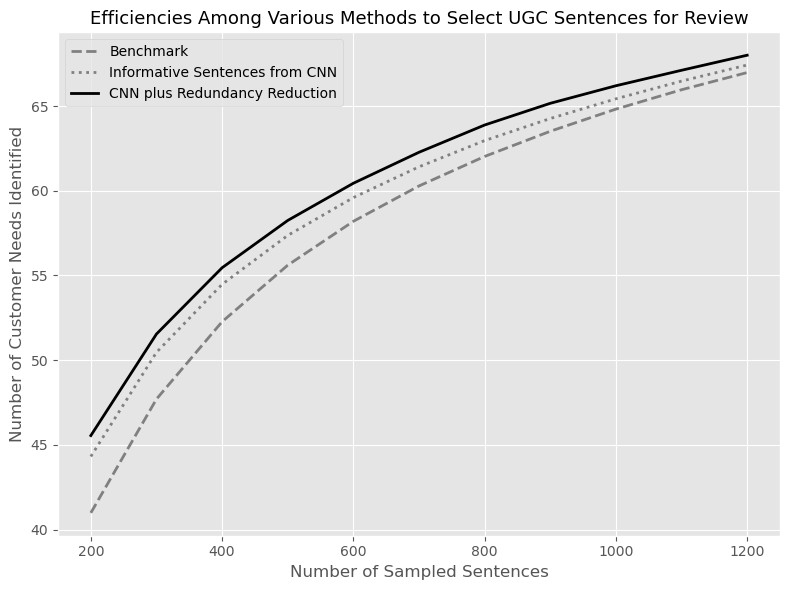

Done.


In [13]:
import csv
import gzip
import random
import warnings
import time
from collections import defaultdict
import numpy as np
# for CNN
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
# For clustering
from sklearn.preprocessing import scale
from scipy.cluster.hierarchy import fcluster, linkage
from joblib import Parallel, delayed 
import matplotlib.pyplot as plt


torch.manual_seed(42)
np.random.seed(42)


def read_emb(emb_file: str) -> dict:
    """
    Reads word or sentence embeddings from a gzipped text file.
    Handling gzip-compressed files.
    Each line is expected to have: token val1 val2 ... valN

    param emb_file: path to a gzipped embeddings file.
    
    return: dict[token -> list of floats]
    """

    word_vecs = {}
    with gzip.open(emb_file, "rt", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split()
            if not parts:
                continue
            token = parts[0]
            emb = [float(s) for s in parts[1:]]
            word_vecs[token] = emb
    return word_vecs


def read_prep_sent(prep_file: str) -> tuple[dict, dict]:
    """
    Reads preprocessed sentences from a gzipped file.
    Each line is expected to have: sentID label word1 word2 ...
    
    param prep_file: path to gzipped file.
    return: (sentPrep, sentLabel)
             sentPrep[sentID] = [word1, word2, ...]
             sentLabel[sentID] = int(label)
    """

    sent_prep = defaultdict(list)
    sent_label = defaultdict(int)
    
    with gzip.open(prep_file, "rt", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split()
            if not parts:
                continue
            snt_id = parts[0]
            label = int(parts[1])
            words = parts[2:]
            sent_prep[snt_id] = words
            sent_label[snt_id] = label
    return sent_prep, sent_label

def read_need_id(need_file: str) -> dict:
    """
    Reads a CSV file of identified needs. Expects a header row, then: sentID, need1, need2, ...
    param need_file: path to CSV.
    return: dict[sentID -> list of needIDs]
    """

    sent_need_id = defaultdict(list)
    with open(need_file, 'r', newline='', encoding='utf-8') as csvfile:
        need_csv = csv.reader(csvfile)
        next(need_csv)  # skip header
        for row in need_csv:
            if not row:
                continue
            snt_id = row[0]
            # Filter out empty strings
            needs = [n for n in row[1:] if n]
            sent_need_id[snt_id] = needs
    return sent_need_id

def read_category_sent(category_file: str, allneeds: list) -> tuple[np.ndarray, ...]:
    """
    Reads a CSV file that categorizes needs into various categories, e.g. high_mention, high_importance, etc. Creates boolean filters.
    Each line has: needID, high_imp, high_perf, hidden_op, high_mention, vlm, vhm, new_need
    The function returns arrays {0/1} for each category, in the order: hm_filter, hi_filter, hp_filter, ho_filter, vlm_filter, vhm_filter, new_filter
    """

    high_mention = []
    high_imp = []
    high_perf = []
    hidden_op = []
    vhm = []
    vlm = []
    new_needs = []
    
    with open(category_file, 'r', newline='', encoding='utf-8') as csvfile:
        cat_csv = csv.reader(csvfile)
        next(cat_csv)  # skip header
        for row in cat_csv:
            need_id = row[0]
            if row[1] == '1': high_imp.append(need_id)
            if row[2] == '1': high_perf.append(need_id)
            if row[3] == '1': hidden_op.append(need_id)
            if row[4] == '1': high_mention.append(need_id)
            if row[5] == '1': vlm.append(need_id)
            if row[6] == '1': vhm.append(need_id)
            if row[7] == '1': new_needs.append(need_id)
    
    hm_filter  = np.array([int(n in high_mention) for n in allneeds])
    hi_filter  = np.array([int(n in high_imp)     for n in allneeds])
    hp_filter  = np.array([int(n in high_perf)    for n in allneeds])
    ho_filter  = np.array([int(n in hidden_op)    for n in allneeds])
    vlm_filter = np.array([int(n in vlm)          for n in allneeds])
    vhm_filter = np.array([int(n in vhm)          for n in allneeds])
    new_filter = np.array([int(n in new_needs)    for n in allneeds])
    
    return hm_filter, hi_filter, hp_filter, ho_filter, vlm_filter, vhm_filter, new_filter


def get_set_needs(sent_list: list, sent_need_id: dict) -> set:
    """
    Given a list of sentence IDs, returns a set of all need IDs mentioned in those sentences.
    """

    return set([need_id for snt in sent_list for need_id in sent_need_id[snt]])

def eval_sent_set(sent_list: list, sent_need_id: dict) -> int:
    """
    Returns the number of distinct needs in the given list of sentences.
    """

    return len(get_set_needs(sent_list, sent_need_id))

def pad_sent(sent_prep: dict, w_emb: dict) -> tuple[dict, dict]:
    """
    Pads all sentences to the same length by adding <PAD> tokens.
    Also adds <PAD> = zero embedding in w_emb.
    """

    max_len = max(len(words) for words in sent_prep.values())
    emb_dim = len(next(iter(w_emb.values())))  # dimension from first embedding
    w_emb['<PAD>'] = [0.0] * emb_dim
    
    for snt, words in sent_prep.items():
        needed = max_len - len(words)
        if needed > 0:
            sent_prep[snt].extend(['<PAD>'] * needed)
    return sent_prep, w_emb

def data_cnn(sent_train: list, w_emb: dict, sent_prep: dict, sent_label: dict) -> tuple[np.ndarray, np.ndarray, torch.Tensor, dict]:
    """
    Prepares data for CNN:
      - Builds a vocabulary from w_emb
      - Maps words to indices
      - Returns x_train, y_train, embedding matrix, vocab
    """

    vocab_in = list(w_emb.keys())
    vocab = {w: i for i, w in enumerate(vocab_in)}

    x_list = []
    for snt in sent_train:
        x_indices = [vocab[w] for w in sent_prep[snt]]
        x_list.append(x_indices)

    x_train = np.array(x_list, dtype=np.int64)
    y_train = np.array([sent_label[snt] for snt in sent_train], dtype=np.float32)
    emb_w_list = [w_emb[w] for w in vocab_in]
    emb_w_tensor = torch.tensor(emb_w_list, dtype=torch.float32)

    return x_train, y_train, emb_w_tensor, vocab

def pick_random(Y: list, N: int) -> list:
    """
    Picks N distinct indices from Y (or len(Y)) at random and returns [Y[i] for i in that subset].
    The argument X is not used in the original code for anything
    """

    idx2pick = sorted(random.sample(range(len(Y)), N))
    return [Y[i] for i in idx2pick]

def get_array_needs(sent_list: list, sent_need_id: dict, allneeds: list) -> np.ndarray:
    """
    Produces a binary array of shape (len(allneeds),) where each entry i is 1 if allneeds[i] is present in any of the sentences in sent_list.
    """

    set_needs = get_set_needs(sent_list, sent_need_id)
    arr = np.array([int(need in set_needs) for need in allneeds], dtype=int)
    return arr

"""
Three Layers:
1. Convolutional Layer: Detect features like phrases or semantic patterns across neighboring words. 
    Each filter slides across the input matrix (e.g., word embeddings for a sentence) and performs element-wise multiplication and summation.
2. Pooling Layer: Reduces the dimensionality of the feature map output from the convolutional layer. 
    Summarize the most important feature detected by each filter.
3. Fully Connected (Dense) Layer: Takes the pooled features and combines them to make final predictions.
"""

class CNNGamma3(nn.Module):
    """
    A CNN with a custom gamma=3 loss for positive classes:
        Loss = -3 * y_true * log(y_pred) - (1 - y_true)*log(1 - y_pred)
    Flow: Embedding -> Dropout -> [Conv1D_k, GlobalMaxPool] -> Concat -> Dense -> Sigmoid
    """

    def __init__(self, vocab_size: int, embedding_dim: int, emb_weights: torch.Tensor,
                 filter_sizes=(3, 4, 5), num_filters=3, dropout_prob=0.3):
        super().__init__()
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        with torch.no_grad():
            self.embedding.weight.copy_(emb_weights)

        self.dropout = nn.Dropout(dropout_prob)

        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim,
                      out_channels=num_filters,
                      kernel_size=fz)
            for fz in filter_sizes
        ])

        # Final dense layer
        self.fc = nn.Linear(num_filters * len(filter_sizes), 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x has shape (batch_size, seq_length).
        Returns shape (batch_size,).
        """

        # Embedding => (batch_size, seq_length, embedding_dim)
        emb = self.embedding(x)
        emb = self.dropout(emb)
        # Permute for Conv1D => (batch_size, embedding_dim, seq_length)
        emb = emb.permute(0, 2, 1)

        # Convolution + Global Max Pool
        conv_outs = []
        for conv in self.convs:
            c = F.relu(conv(emb))  # => (batch_size, num_filters, new_seq_length)
            pooled = F.max_pool1d(c, kernel_size=c.shape[2])  # => (batch_size, num_filters, 1)
            conv_outs.append(pooled.squeeze(2))               # => (batch_size, num_filters)

        # Concat
        cat = torch.cat(conv_outs, dim=1)  # => (batch_size, num_filters * #filter_sizes)

        # Dense => sigmoid
        out = self.fc(cat).squeeze(1)
        out = torch.sigmoid(out)
        return out

def custom_loss_gamma3(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    """
    Implements gamma=3 loss: -3*y_true*log(y_pred) - (1-y_true)*log(1-y_pred)
    Clamp y_pred to avoid log(0).
    """

    eps = 1e-7
    y_pred = torch.clamp(y_pred, eps, 1 - eps)
    loss = -3 * y_true * torch.log(y_pred) - (1 - y_true) * torch.log(1 - y_pred)
    return loss.mean()

# custom_loss_gamma3 is used to train the CNNGamma3 model.

def train_and_apply_cnn(sent_train: list,
                        w_emb: dict,
                        sent_prep: dict,
                        sent_label: dict,
                        sent_test: list) -> np.ndarray:
    """
    Equivalent to the original 'train_and_apply_CNN' but with PyTorch instead of Keras.
    1) Prepares the data (x_train, y_train).
    2) Builds and trains a CNN with gamma=3 cost.
    3) Predicts 0/1 on x_test.
    return: A NumPy array yhat of shape (len(sent_test),) with 0/1 predictions.
    """

    # 1) Data prep
    x_train_np, y_train_np, emb_w_tensor, vocab = data_cnn(sent_train, w_emb, sent_prep, sent_label)
    sequence_length = x_train_np.shape[1]  # number of tokens
    vocab_size = emb_w_tensor.shape[0]
    embedding_dim = emb_w_tensor.shape[1]

    # Convert to Tensors for training
    x_train_t = torch.tensor(x_train_np, dtype=torch.long)
    y_train_t = torch.tensor(y_train_np, dtype=torch.float32)


    # 2) Define model & training
    filter_sizes = (3, 4, 5)
    num_filters = 3
    dropout_prob = 0.3
    batch_size = 32
    num_epochs = 40
    val_split = 0.1

    patience = 5


    model = CNNGamma3(
        vocab_size=vocab_size,
        embedding_dim=embedding_dim,
        emb_weights=emb_w_tensor,
        filter_sizes=filter_sizes,
        num_filters=num_filters,
        dropout_prob=dropout_prob

    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.RMSprop(model.parameters(), lr=1e-3)

    # Split train/val
    n_samples = x_train_t.shape[0]
    val_count = int(n_samples * val_split)
    train_count = n_samples - val_count
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    train_idx = indices[:train_count]
    val_idx = indices[train_count:]
    x_val_t = x_train_t[val_idx].to(device)
    y_val_t = y_train_t[val_idx].to(device)
    x_train_t = x_train_t[train_idx].to(device)
    y_train_t = y_train_t[train_idx].to(device)
    best_val_loss = float('inf')
    epochs_no_improve = 0


    for epoch in range(num_epochs):
        model.train()
        # Shuffle train
        perm = np.random.permutation(train_count)
        for i in range(0, train_count, batch_size):
            batch_idx = perm[i:i+batch_size]
            x_batch = x_train_t[batch_idx]
            y_batch = y_train_t[batch_idx]
            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = custom_loss_gamma3(y_pred, y_batch)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()

        with torch.no_grad():
            y_val_pred = model(x_val_t)
            val_loss = custom_loss_gamma3(y_val_pred, y_val_t).item()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                break


    # 3) Predict on test set
    x_test_np = []
    for snt in sent_test:
        x_test_np.append([vocab[w] for w in sent_prep[snt]])
    x_test_t = torch.tensor(x_test_np, dtype=torch.long).to(device)
    model.eval()

    with torch.no_grad():
        y_prob = model(x_test_t).cpu().numpy()  # shape (len(sent_test),)
    yhat = (y_prob > 0.5).astype(int)

    return yhat

def run_one_iteration(
    all_sent, snt_emb, w_emb, sent_prep, sent_label, sent_need_id, allneeds, FILTER,
    testN, T, len_set
):
    """
    For Figure_7_parallel
    Runs exactly one iteration of:
      - Split train/test
      - Train CNN
      - Identify predicted-positive
      - For each sample_size in len_set:
          * Random sampling from test
          * Random sampling from identified
          * Hierarchical clustering on identified
    Returns partial accumulations for: perform_random_test, perform_random_ident, perform_hc
    plus summary statistics (precision, recall, # identified, etc.), if desired.
    """

    # Initialize partial accumulations
    S = len(len_set)
    part_random_test  = np.zeros((S,))
    part_random_ident = np.zeros((S,))
    part_hc           = np.zeros((S,))

    # 1) Split train/test
    sent_test_indices = sorted(random.sample(range(len(all_sent)), testN))
    sent_test = [all_sent[i] for i in sent_test_indices]
    sent_train = list(set(all_sent) - set(sent_test))


    # 2) Train CNN => predictions on test
    yhat = train_and_apply_cnn(sent_train, w_emb, sent_prep, sent_label, sent_test)
    # Identify predicted-positive
    ident_sent = [sent_test[i] for i in range(len(sent_test)) if yhat[i] == 1]

    # 3) Precision & recall for classification
    y_test = np.array([sent_label[snt] for snt in sent_test])
    TP = np.sum((y_test == yhat) & (y_test == 1))
    FP = np.sum((y_test != yhat) & (y_test == 0))
    FN = np.sum((y_test != yhat) & (y_test == 1))
    prec = (TP / (TP + FP)) if (TP + FP) else 0.0
    rec  = (TP / (TP + FN)) if (TP + FN) else 0.0
    len_id = len(ident_sent)


    # 4) For each sample size in len_set, do T picks
    # 4a) random from full test set
    for s_idx, sample_size in enumerate(len_set):
        for _ in range(T):
            sample_test = pick_random(sent_test, sample_size)
            sample_needs = get_array_needs(sample_test, sent_need_id, allneeds)
            part_random_test[s_idx] += np.sum(sample_needs * FILTER)

    # 4b) random from identified
    for s_idx, sample_size in enumerate(len_set):
        for _ in range(T):
            sample_ident = pick_random(ident_sent, sample_size)
            sample_needs = get_array_needs(sample_ident, sent_need_id, allneeds)
            part_random_ident[s_idx] += np.sum(sample_needs * FILTER)

    # 4c) hierarchical clustering on identified
    X_list = [snt_emb[s] for s in ident_sent]
    if len(X_list) > 1:
        from scipy.cluster.hierarchy import fcluster, linkage
        from sklearn.preprocessing import scale

        X_mat = np.array(X_list, dtype=float)
        Z = linkage(scale(X_mat), method='ward')
        for s_idx, sample_size in enumerate(len_set):
            cluster_labels = fcluster(Z, sample_size, criterion='maxclust')
            cluster_dict = defaultdict(list)
            for i, clab in enumerate(cluster_labels):
                cluster_dict[clab].append(ident_sent[i])
            for _ in range(T):
                sample_iter = [random.choice(cluster_dict[cl_]) for cl_ in cluster_dict]
                sample_needs = get_array_needs(sample_iter, sent_need_id, allneeds)
                part_hc[s_idx] += np.sum(sample_needs * FILTER)


    # Return partial arrays (divide by T right here or in main)
    return (
        part_random_test,
        part_random_ident,
        part_hc,
        prec,
        rec,
        len_id
    )


if __name__ == "__main__":
    warnings.filterwarnings("ignore")

    # 1) File paths
    short_emb_file = '../temp/short_emb_20.txt.gz'
    sent_emb_file  = '../temp/sent_emb_20.txt.gz'
    prep_sent_file = '../temp/preprocessed_snts.txt.gz'
    needs_file     = '../data/identified_needs.csv'
    need_filter_file = '../data/need_filters.csv'

    # 2) Read data
    w_emb = read_emb(short_emb_file)
    snt_emb = read_emb(sent_emb_file)
    sent_prep, sent_label = read_prep_sent(prep_sent_file)
    sent_need_id = read_need_id(needs_file)
    # Pad sentences
    sent_prep, w_emb = pad_sent(sent_prep, w_emb)
    # All sentence IDs
    all_sent = list(sent_prep.keys())
    # All needs
    allneeds_set = get_set_needs(all_sent, sent_need_id)
    allneeds = sorted(list(allneeds_set))  # fix order to make it consistent

    N = len(allneeds)  # total distinct needs
    # Read category filters
    (hm_filter, hi_filter, hp_filter, ho_filter,
     vlm_filter, vhm_filter, new_filter) = read_category_sent(need_filter_file, allneeds)

    # For no filter:
    no_filter = np.ones((N,), dtype=int)
    lm_filter = 1 - hm_filter  # etc., as needed

    FILTER = no_filter  # can switch to other filters if desired

    # 3) Some parameters (same logic as original)
    testN = 3000    # number of test sentences
    L = 300         # outer loop
    T = 200         # number of repeated picks for random sampling
    len_set = [200,300,400,500,600,700,800,900,1000,1100,1200]
    S = len(len_set)

    # Performance arrays
    perform_random_test = np.zeros(shape=(S,))
    perform_random_ident = np.zeros(shape=(S,))
    perform_hc = np.zeros(shape=(S,))
    train_needs = np.zeros(shape=(L, N))
    test_needs = np.zeros(shape=(L, N))
    ident_needs = np.zeros(shape=(L, N))


    precision_array = np.zeros(shape=(L, 1))
    recall_array = np.zeros(shape=(L, 1))
    len_ident = np.zeros(shape=(L, 1))


    # 4) Main loop
    results = Parallel(n_jobs=-1, verbose=5)(
    delayed(run_one_iteration)(
        all_sent, snt_emb, w_emb, sent_prep, sent_label, sent_need_id, allneeds, FILTER,
        testN, T, len_set
    ) 
    for _ in range(L)  # for l_iter in range(L)
    )

    # 'results' is a list of length L, each item is: (part_random_test, part_random_ident, part_hc, prec, rec, len_id)
    # 3) Aggregate
    for i, res in enumerate(results):
        part_rt, part_ri, part_hc_, prec, rec, l_id = res
        perform_random_test  += part_rt
        perform_random_ident += part_ri
        perform_hc           += part_hc_
        precision_array[i] = prec
        recall_array[i]    = rec
        len_ident[i]       = l_id

    # Now each partial array is "accumulated" across L.
    # The original code divides by (T*L) inside the loop, but I do it here:
    perform_random_test  /= (T*L)
    perform_random_ident /= (T*L)
    perform_hc           /= (T*L)

    # 4) Plot final figure
    plt.figure(figsize=(8,6))
    plt.plot(len_set, perform_random_test,  label='Benchmark', color='gray', linestyle='--', linewidth=2)
    plt.plot(len_set, perform_random_ident, label='Informative Sentences from CNN', color='gray', linestyle=':', linewidth=2)
    plt.plot(len_set, perform_hc,           label='CNN plus Redundancy Reduction', color='black', linewidth=2)

    plt.xlabel('Number of Sampled Sentences', fontsize=12)
    plt.ylabel('Number of Customer Needs Identified', fontsize=12)
    plt.title('Efficiencies Among Various Methods to Select UGC Sentences for Review', fontsize=13)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig('../figure/Figure_7_parallel.png')
    plt.show()

    print("Done.")
